In [1]:
# default_exp learn

In [2]:
#export 
import pandas as pd
from pymongo import MongoClient
from pathlib import Path
import shutil
from mytools.tools import *
from fur.paths import *
from annoy import AnnoyIndex

from fastai.vision.all import *

import nested_lookup

In [3]:
#export
def save_file_from_url(url, fname):
    r = requests.get(url, allow_redirects=True)
    open(fname, 'wb').write(r.content)

In [339]:
def images_df():
    pics_path = ssd_pictures_path
#     pics_path = Path('/home/dima/houzz_parse/PICS')
    mongo_connect = MongoClient('mongodb://localhost:27017')
    mongodb = mongo_connect['houzz']
    cursor =mongodb['FurnitureItem'].find()
    data = list(cursor)
    pics = pd.DataFrame(list(pics_path.ls()),columns=['paths'])
    pics['file_name'] = pics['paths'].apply(lambda x:x.name)
    pics['image'] = pics['file_name'].str.split('_').str[0]
    data_filtered = nested_lookup.nested_delete(data,'url_img_product')
    img_keys = nested_lookup.nested_lookup('url_img_product',data)
    img_keys = [list(item.keys()) for item in img_keys]
    df = pd.json_normalize(data_filtered)
    df.columns = [c.split('.')[1] if len(c.split('.'))>1 else c for c in df.columns ]
    df['image'] = img_keys
    df = df.explode('image')
    df = pics.merge(df,on='image')
    df = df.drop_duplicates('image').reset_index(drop=True)
    df.columns = df.columns.str.lower()
    return df.drop(columns=['file_name','image','_id'])

In [477]:
#export
def mk_model_dir(learner_name):
    model_name = f'model_{learner_name}_{pd.Timestamp.now()}'
    model_path = models_path/model_name
    if not model_path.is_dir(): model_path.mkdir()
    return model_path

In [5]:
len(ssd_pictures_path.ls())

194442

In [341]:
mapping_df

,paths,url,manufactured by,sold by,size/weight,color,materials,assembly required,category,style,collection,amount,currency,commercial-grade,size,weight,designer
0,/home/dima/ssd/furniture_data/pictures/f3912f5007322a53_4-2628.jpg,https://www.houzz.com/products/puerto-counter-height-stool-with-black-frame-purple-weave-black-frame-prvw-vr~54394155,Innit Designs,Innit Designs,"W 25"" / D 20"" / H 40"" / 22 lb.",Purple Weave,Steel and Vinyl,NaN,Bar Stools And Counter Stools,Contemporary,Puerto Bar Stools,475,USD,Yes,NaN,NaN,NaN
1,/home/dima/ssd/furniture_data/pictures/0f119b8e0e139b63_4-1400.jpg,https://www.houzz.com/products/novogratz-regal-mid-century-sofa-bed-futon-mustard-yellow-prvw-vr~152724942,Novogratz,Houzz,"W 80.5"" / D 33.5"" / H 32.5"" / 91.5 lb.",Mustard Yellow,Wood,Yes,Living Room Furniture,Midcentury,Regal,534,USD,NaN,NaN,NaN,NaN
2,/home/dima/ssd/furniture_data/pictures/87b177400cfe92cb_4-8234.jpg,https://www.houzz.com/products/haugen-reclaimed-wood-traditional-hand-carved-console-table-prvw-vr~144104406,Sierra Living Concepts,Sierra Living Concepts,"W 47"" / D 15"" / H 29"" / 70 lb.",NaN,Solid Wood,No,Console Tables,Mediterranean,NaN,899,USD,NaN,NaN,NaN,NaN
3,/home/dima/ssd/furniture_data/pictures/6b41a2140f907733_4-3884.jpg,https://www.houzz.com/products/gdf-studio-lexi-modern-velvet-barstools-turquoise-set-of-2-prvw-vr~127303765,GDFStudio,GDFStudio,"W 21.5"" / D 17.75"" / H 40"" / 16.76 lb.",Turquoise,"New Velvet, Iron",Yes,Bar Stools And Counter Stools,Contemporary,NaN,182,USD,NaN,NaN,NaN,NaN
4,/home/dima/ssd/furniture_data/pictures/a31138c10c1aa8ed_4-5493.jpg,https://www.houzz.com/products/safavieh-greta-accent-table-steel-teal-prvw-vr~105141239,Safavieh,Houzz,"W 22"" / D 22"" / H 29"" / 10 lb.",Steel Teal,Pine,Yes,Side Tables And End Tables,Traditional,NaN,186.51,USD,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191954,/home/dima/ssd/furniture_data/pictures/27a168fc077fa7f8_4-6738.jpg,https://www.houzz.com/products/flash-furniture-contemporary-black-vinyl-adjustable-h-bar-stool-prvw-vr~59367194,Flash Furniture,BisonOffice,NaN,Black,NaN,Yes,Bar Stools And Counter Stools,Contemporary,NaN,117.6,USD,NaN,"W 16"" / D 19"" / H 44""",NaN,NaN
191955,/home/dima/ssd/furniture_data/pictures/7bb12fd10c2e1408_4-4648.jpg,https://www.houzz.com/products/eva-sofette-mod-velvet-vanilla-prvw-vr~116417485,NyeKoncept,Houzz,"W 55.4"" / D 30.75"" / H 35.25"" / 68 lb.",Vanilla,"Mod Velvet, Solid Ash Wood",Yes,Loveseats,Midcentury,NaN,1104,USD,NaN,NaN,NaN,NaN
191956,/home/dima/ssd/furniture_data/pictures/2911cab60b23e0b6_4-4796.jpg,https://www.houzz.com/products/acme-baudouin-upholstered-queen-bed-weathered-oak-26110q-prvw-vr~156773461,Acme Furniture,Emma Mason,"W 88"" / D 66"" / H 59"" / 156 lb.",Oak,Wood,Yes,Panel Beds,Traditional,NaN,972.5,USD,NaN,NaN,NaN,NaN
191957,/home/dima/ssd/furniture_data/pictures/0f219e1b0f5fe2e0_4-8511.jpg,https://www.houzz.com/products/harper-reversible-chaise-sleeper-sofa-marigold-velvet-innerspring-mattress-prvw-vr~121156644,Apt2B,Apt2B,"W 86"" / D 37"" / H 30"" / 120 lb.",Marigold Velvet,"Solid Wood Frame, Hypoallergenic Fabrics, Foam Cushioning",No,Sleeper Sofas,Contemporary,Harper,2590.8,USD,NaN,NaN,NaN,NaN


In [491]:
mapping_df = images_df()

mapping_df = mapping_df[mapping_df['category']=='Sofas'].reset_index(drop=True)
mapping_df = mapping_df[['paths','color','materials','style']]

In [492]:
len(mapping_df['color'].unique())

743

In [493]:
mapping_df['color'] = mapping_df['color'].str.lower()

In [494]:
mapping_df['color'] = mapping_df['color'].str.split(' ')

In [495]:
mapping_df = mapping_df.explode('color')

In [496]:
mapping_df['color'] = mapping_df['color'].str.split('/')

In [497]:
mapping_df = mapping_df.explode('color')

In [498]:
pdrows(50)

In [499]:
color = mapping_df.groupby(['color'])['paths'].count().sort_values(ascending=False)[:50].index

In [500]:
color = color.drop('light','finish:')

In [501]:
len(color)

49

In [502]:
mapping_df.loc[~mapping_df['color'].isin(color),'color'] = np.nan

In [503]:
mapping_df = mapping_df.reset_index().sort_values('color',ascending=False).drop_duplicates('index').set_index('index').sort_index()

In [504]:
len(mapping_df)

25588

In [505]:
pdrows(10)

In [506]:
# mapping_df['Materials'] = mapping_df['Materials'].str.lower()
# mapping_df['Materials'] = mapping_df['Materials'].str.replace('/',',').str.strip()

In [507]:
# selected_colors = (mapping_df.groupby('Color')['paths'].count().sort_values(ascending=False)[:100]).index
# mapping_df = mapping_df[mapping_df['Color'].isin(selected_colors)]

In [508]:
# selected_materials = mapping_df.groupby('Materials')['paths'].count().sort_values(ascending=False)[:50].index
# mapping_df = mapping_df[mapping_df['Materials'].isin(selected_materials)]

In [509]:
mapping_df['labels'] = mapping_df['color']+','+mapping_df['style']#+','+mapping_df['Materials']

In [510]:
mapping_df = mapping_df[['paths','labels']]

In [511]:
mapping_df['paths'] = mapping_df['paths'].apply(lambda x:x.name)

In [512]:
mapping_df = mapping_df.dropna()

In [513]:
mapping_df.loc[mapping_df.sample(int(len(mapping_df)/5)).index,'is_valid'] = True

In [514]:
mapping_df['is_valid'] = mapping_df['is_valid'].fillna(False)

In [515]:
len(mapping_df)

18489

In [516]:
drop_labels = set(mapping_df[mapping_df['is_valid']==True]['labels'])^set(mapping_df[mapping_df['is_valid']==False]['labels'])

In [517]:
mapping_df = mapping_df[~mapping_df['labels'].isin(drop_labels)]

In [620]:
len(mapping_df['labels'].unique())

164

In [621]:
dls = ImageDataLoaders.from_df(mapping_df, path = ssd_pictures_path, 
                               label_col=1, item_tfms=Resize(224), valid_col='is_valid')

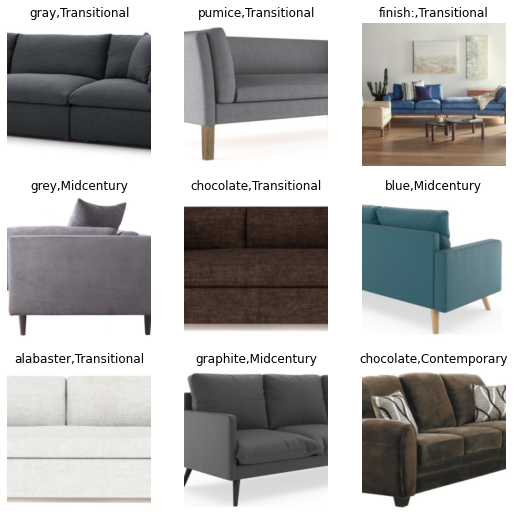

In [622]:
dls.show_batch()

#### learn

In [623]:
learn = cnn_learner(dls,resnet34, metrics=error_rate)#, metrics=partial(accuracy_multi, thresh=0.5)

In [624]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,3.425008,2.294852,0.544372,00:31


epoch,train_loss,valid_loss,error_rate,time
0,1.899447,1.403769,0.357955,00:41
1,1.223142,1.124472,0.283820,00:41


#### extra train

In [625]:
learn.unfreeze()

SuggestedLRs(lr_min=9.120108734350651e-06, lr_steep=1.9054607491852948e-06)

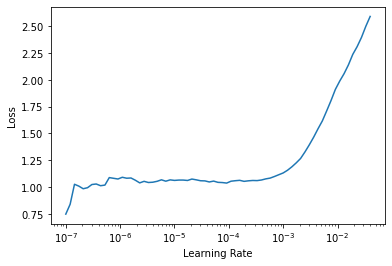

In [626]:
learn.lr_find()

In [627]:
learn.fit_one_cycle(2, slice(2e-6, 1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.992909,1.098902,0.277597,00:40
1,0.949530,1.090592,0.277056,00:40


In [1077]:
selected = mapping_df[mapping_df['labels']=='beige,Traditional'].head()

In [1078]:
for p in selected['paths']:
    Image(p)

#### interpret

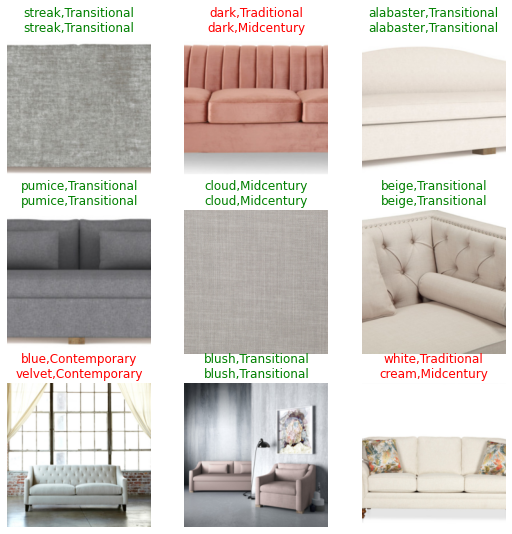

In [629]:
learn.show_results()

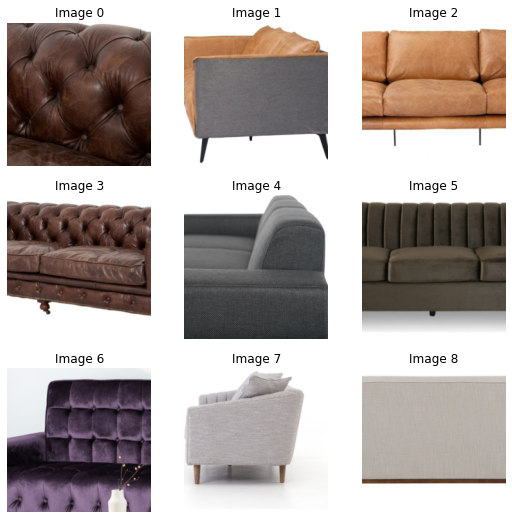

In [334]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

#### save model

In [630]:
model_path = mk_model_dir('sofas_styles__color_singlelabel_10_11')

In [631]:
learn.export(model_path/'model.pkl')

#### load model 

In [71]:
learn = load_learner(model_path)

In [72]:
learn.dls = dls

In [1079]:
similar_labled = mapping_df[mapping_df['labels']=='beige,Traditional']['paths'].tolist()

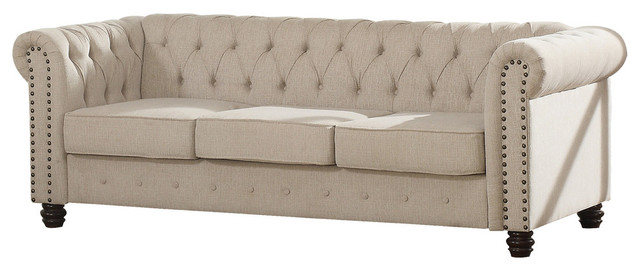

In [1089]:
Image(filename =ssd_pictures_path/similar_labled[8])

### annoy

In [632]:
# export 
# this is a hook (learned about it here: https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903/13)
# hooks are used for saving intermediate computations
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [952]:
sf = SaveFeatures(learn.model[1][4])

In [953]:
preds= learn.get_preds(ds_idx=1)

In [954]:
# _= learn.get_preds(ds_idx=1)

In [955]:
len(sf.features)

3696

In [956]:
img_path = [str(x) for x in list(dls.valid_ds.items['paths'])];len(img_path)

3696

In [957]:
img_path

['10616e950e910027_4-5106.jpg',
 'b1f13af80f15e32f_4-9765.jpg',
 '8fe1bf4a0aeb7049_4-6645.jpg',
 'e0915acc0f5fe5eb_4-9907.jpg',
 '71d10d2a0f907806_4-3788.jpg',
 '9131d4f90c6ca0c9_4-2117.jpg',
 'ed71b69a0d83b82c_4-2294.jpg',
 'df8125890dd6acb6_4-0013.jpg',
 '8dc1d3090d9df961_4-9594.jpg',
 '9681ba010f9070bd_4-3749.jpg',
 '98f1f1c50aeb770f_4-0952.jpg',
 '3461f0a80bc0e397_4-1773.jpg',
 '6fa10fcf0aeb75bd_4-0546.jpg',
 '2ed109f70c6ca0c7_4-2125.jpg',
 '24b164c20dd6ad7a_4-0195.jpg',
 '71b1f95f0d9dfbeb_4-0989.jpg',
 'ff1142680d826866_4-0169.jpg',
 '70a142540d092b3a_4-0598.jpg',
 '77d1c67c0aeb79fb_4-6198.jpg',
 '02814e190aeb6a6c_4-7646.jpg',
 '94c1f5ff0ee75016_4-5437.jpg',
 '3c8110190dd6aca2_4-9381.jpg',
 '315199db0aeb692a_4-7327.jpg',
 'e49184340aeb727c_4-9710.jpg',
 'adc153a20aeb7577_4-0481.jpg',
 'a0513c250dd6ae85_4-9890.jpg',
 '38d1f0340dd6addf_4-0576.jpg',
 '3c8134a40dd6ae35_4-0990.jpg',
 '4071520506d09ab5_4-7457.jpg',
 '85b18a25086572d5_4-3117.jpg',
 'e53171320dd80047_4-8522.jpg',
 '11618b

In [1010]:
sf.features = Tensor(sf.features).pca(2)

In [1011]:
feature_dict = dict(zip(img_path,sf.features));len(feature_dict)

3696

In [1012]:
# to_pickle(feature_dict,model_path/'feature_dict.pkl')

In [1013]:
feature_dim = len(next(iter(feature_dict.values())))
t = AnnoyIndex(feature_dim, metric='euclidean')

for i, vector in enumerate(feature_dict.values()):
    t.add_item(i, vector)

In [1014]:
vector.shape

torch.Size([2])

In [1015]:
t.build(10) # 10 trees

True

In [1016]:
t.save(str(model_path/'test1.ann'))

True

##### test

In [1017]:
from IPython.display import Image,display

In [932]:
similar = t.get_nns_by_vector(sf.features[-1], 1, search_k=-1, include_distances=False)

[14367]

In [934]:
label_df = mapping_df[mapping_df['paths'].isin([list(feature_dict.keys())[i] for i in similar])];label_df

,paths,labels,is_valid
index,,,
25004,d7e10e790aeb740e_4-0114.jpg,"ivory,Midcentury",False


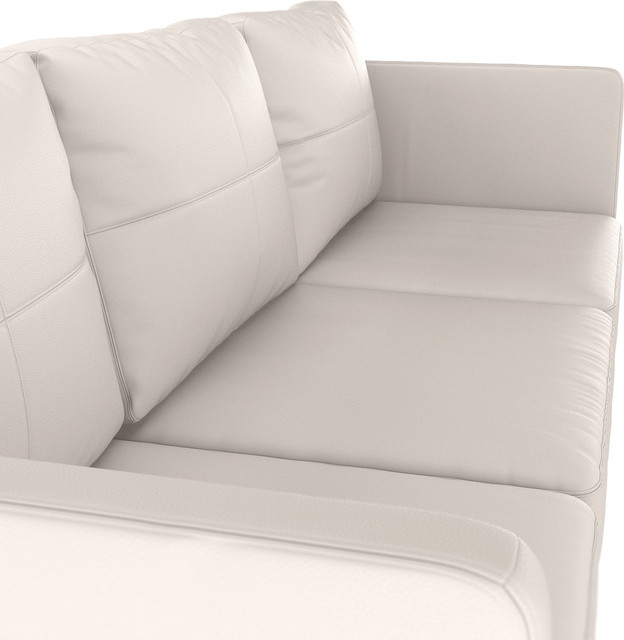

10607

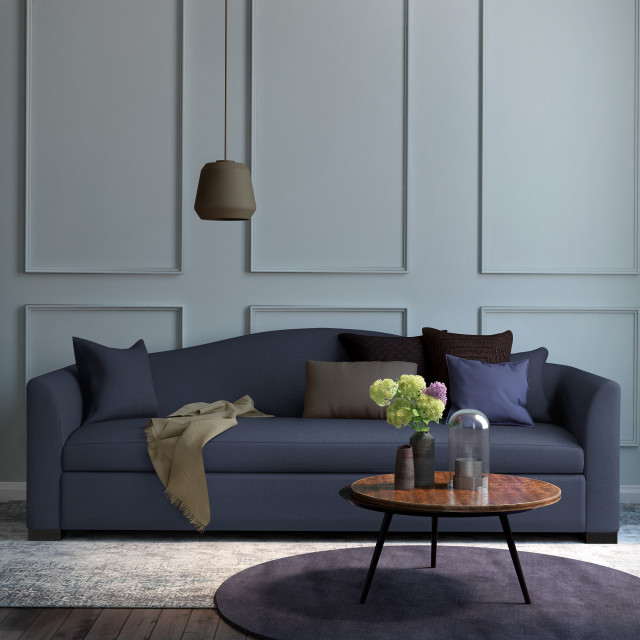

In [798]:
Image(ssd_pictures_path/list(feature_dict.keys())[similar[0]])

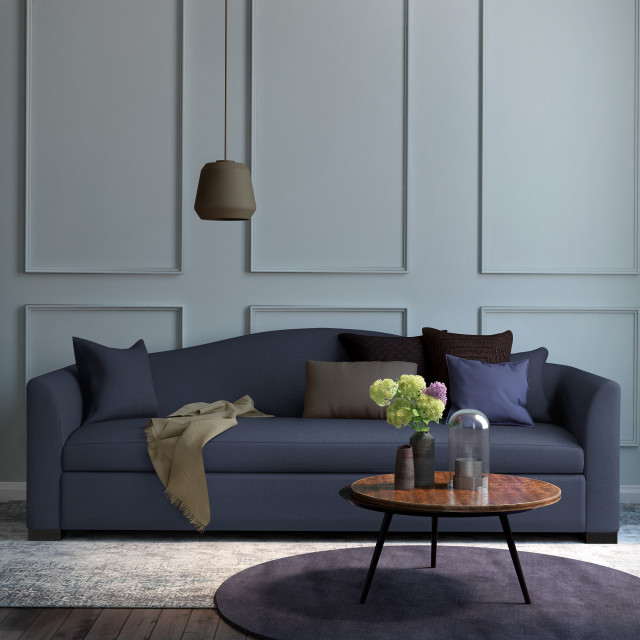

In [790]:
for i in similar:
    display(Image(filename =ssd_pictures_path/list(feature_dict.keys())[i], width=500, height=500))

In [776]:
i

4025

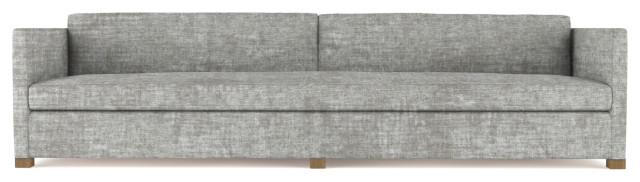

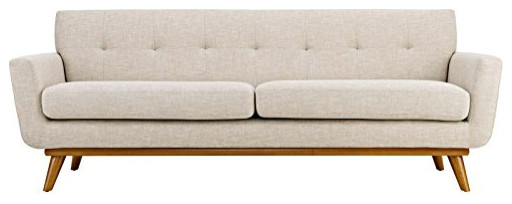

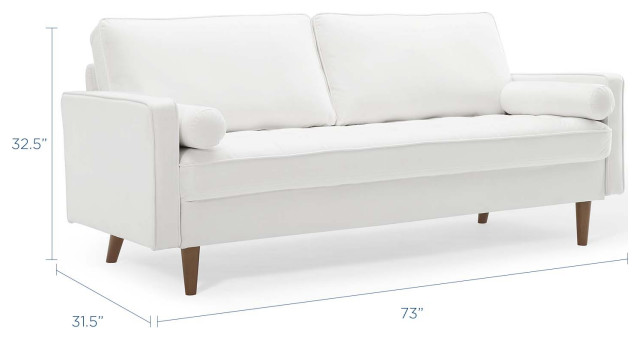

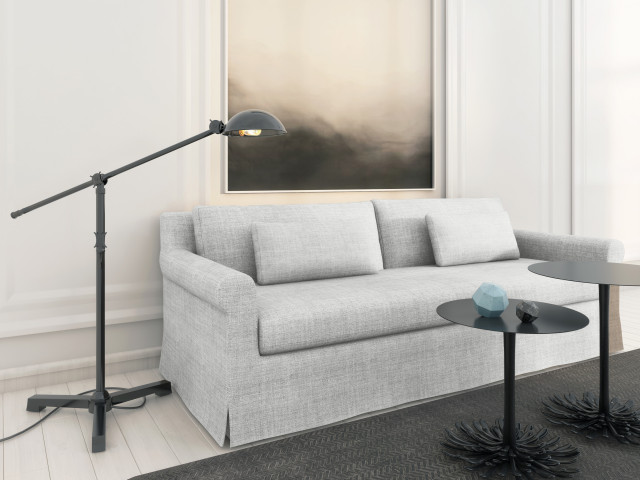

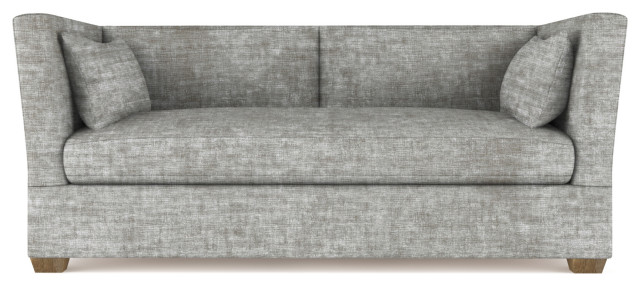

In [781]:
for i in similar:
    display(Image(filename =ssd_pictures_path/list(feature_dict.keys())[i], width=500, height=500))